In [1]:
from __future__ import annotations

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import itertools

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors
rc("font", **{"family": "serif", "serif": ["Times"]})
rc("text", usetex=True)

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from Datasets import Data
from NeuralNetwork import NeuralNetwork

import seaborn as sns

import os


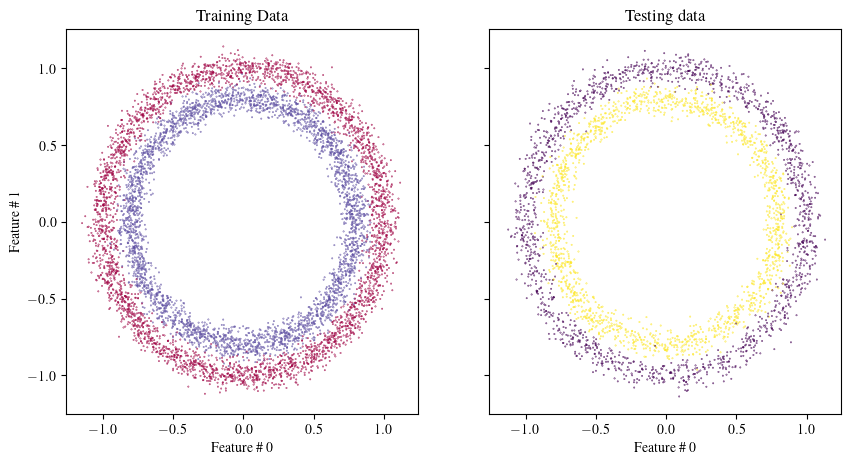

In [2]:
# Create a dataset with 10,000 samples.
X, y = make_circles(n_samples=10000, noise=0.05, random_state=26)

# make_circles = Make a large circle containing a smaller circle in 2d. 
# A simple toy dataset to visualize clustering and classification algorithms.
# where, n_samples = total number of points generated, noise = Standard deviation of Gaussian noise added to the data, 
# random_state = Determines random number generation for dataset shuffling and noise. Pass an int for reproducible output across multiple function calls.
# Returns, X = The generated samples, y = The integer labels (0 or 1) for class membership of each sample.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=26
)

# train_test_split = Split arrays or matrices into random train and test subsets where, test_size = If float, should be between 0.0 and 1.0 and 
# represent the proportion of the dataset to include in the test split. If int, represents the absolute number of test samples. If None, the value 
# is automatically set to the complement of the train size, random_state = Controls the shuffling applied to the data before applying the split. 
# Pass an int for reproducible output across multiple function calls. Returns, List containing train-test split of inputs.

# Visualize the data.
fig, (train_ax, test_ax) = plt.subplots(
    ncols=2, sharex=True, sharey=True, figsize=(10, 5)
)
train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral, s=0.1)
train_ax.set_title(r"Training Data")
train_ax.set_xlabel(r"Feature \# 0")
train_ax.set_ylabel(r"Feature \# 1")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=0.1)
test_ax.set_xlabel(r"Feature \# 0")
test_ax.set_title(r"Testing data")
plt.savefig(os.path.join(os.getcwd(), "datasets.png"), dpi=500)
plt.show()

In [3]:
batch_size = 64

# Instantiate training and test data
train_data = Data(X_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Data(X_test, y_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

# Check it's working
for batch, (X, y) in enumerate(train_dataloader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    break

Batch: 1
X shape: torch.Size([64, 2])
y shape: torch.Size([64])


In [4]:
input_dim = 2
hidden_dim = 10
output_dim = 1

model = NeuralNetwork(input_dim, hidden_dim, output_dim)
print(model)

NeuralNetwork(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=1, bias=True)
)


In [5]:
# To train the model we must define a loss function to use to calculate the gradients and an optimizer to update the parameters. 

learning_rate = 0.1

loss_fn = nn.BCELoss() # binary crossentropy as loss function 

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # stochastic gradient descent as optimizer 

In [6]:
num_epochs = 100
loss_values = []
test_loss_values = []

for epoch in range(num_epochs):
    model.train()  # Ensure the model is in training mode during training

    # Training phase (this part is the same as your original code)
    for X, y in train_dataloader:
        optimizer.zero_grad()  # Zero the parameter gradients
        pred = model(X)  # Forward pass
        loss = loss_fn(pred, y.unsqueeze(-1))  # Calculate the loss
        loss_values.append(loss.item())  # Track loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize the model parameters

    # After each epoch, evaluate on the test dataset
    model.eval()  # Set model to evaluation mode for test evaluation

    with torch.no_grad():  # Disable gradient computation during evaluation
        for X_test, y_test in test_dataloader:
            # Forward pass on the test set
            pred_test = model(X_test)
            
            # Calculate test loss
            loss_test = loss_fn(pred_test, y_test.unsqueeze(-1))
            
            # Track the test loss
            test_loss_values.append(loss_test.item())

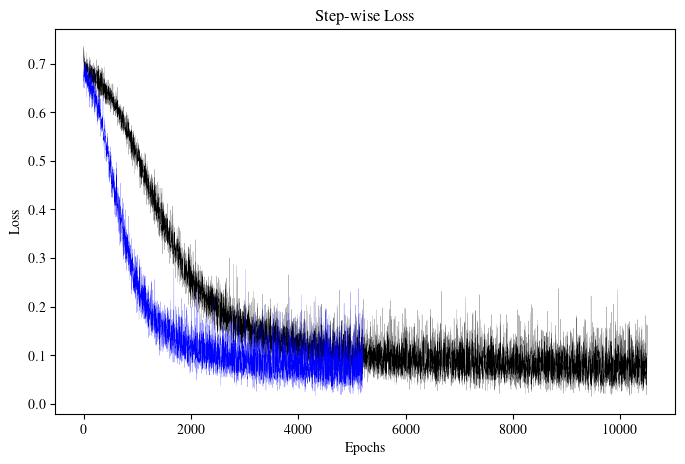

In [7]:
step = range(len(loss_values))
step_test = range(len(test_loss_values))

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values), c='black', lw=0.1)
plt.plot(step_test, np.array(test_loss_values), c='blue', lw=0.1)
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig(os.path.join(os.getcwd(), "loss.png"), dpi=500)
plt.show()

In [8]:
# Initialize required variables
y_pred = []
y_test = []
correct = 0
total = 0

In [9]:
# We're not training so we don't need to calculate the gradients for our outputs

with torch.no_grad():
        for X, y in test_dataloader:
            outputs = model(X)  # Get model outputs
            predicted = np.where(outputs.numpy() < 0.5, 0, 1)  # Convert to NumPy and apply threshold
            predicted = list(itertools.chain(*predicted))  # Flatten predictions
            y_pred.append(predicted)  # Append predictions
            y_test.append(y.numpy())  # Append true labels as NumPy

            total += y.size(0)  # Increment total count
            correct += (predicted == y.numpy()).sum().item()  # Count correct predictions


"""
The code above loops through the test batches, which are stored in the test_dataloader variable, without calculating the gradients. 
We then predict the instances in the batch and store the results in a variable called outputs. Next, we determine set all the values 
less than 0.5 to 0 and those equal to or greater than 0.5 to 1. These values are then appended to a list for our predictions.

After that, we add the actual predictions of the instances in the batch to a variable named total. Then we calculate the number of 
correct predictions by identifying the number of predictions equal to the actual classes and totaling them. The total number of 
correct predictions for each batch is incremented and stored in our correct variable.

To calculate the accuracy of the overall model, we multiply the number of correct predictions by 100 (to get a percentage) and 
then divide it by the number of instances in our test set. Our model had 97% accuracy. 
"""

print(f'Accuracy of the network on the 3300 test instances: {100 * correct // total}%')

Accuracy of the network on the 3300 test instances: 97%


In [10]:
"""
We dig in further using the confusion matrix and scikit-learn's classification_report to get a better understanding of how our model 
performed.
"""

"\nWe dig in further using the confusion matrix and scikit-learn's classification_report to get a better understanding of how our model \nperformed.\n"

In [11]:
y_pred = list(itertools.chain(*y_pred))
y_test = list(itertools.chain(*y_test))

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97      1635
         1.0       0.99      0.96      0.97      1665

    accuracy                           0.97      3300
   macro avg       0.97      0.97      0.97      3300
weighted avg       0.97      0.97      0.97      3300



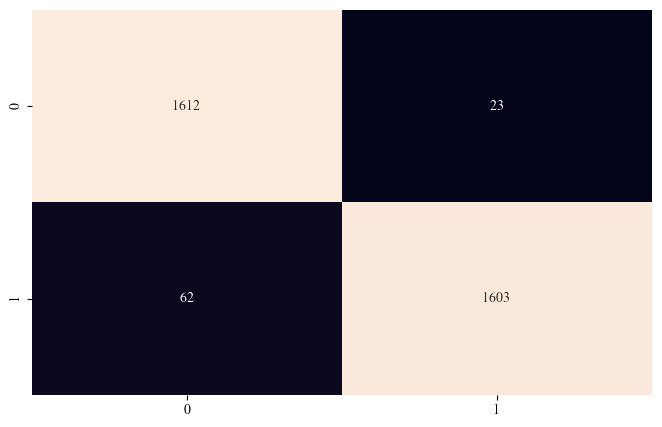

In [12]:
cf_matrix = confusion_matrix(y_test, y_pred)

plt.subplots(figsize=(8, 5))

sns.heatmap(cf_matrix, annot=True, cbar=False, fmt="g")

plt.savefig(os.path.join(os.getcwd(), "confusionmatrix.png"), dpi=500)
plt.show()